In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image

# Parser

In [4]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="100", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-2, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default=r"C:\Users\Tianqin Li\Code\PGM-project\train_related", help="save path")
parser.add_argument("--subfolder", type=str, default=r'\baseline_st', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")


args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH]
                             [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Tianqin Li\AppData\Roaming\jupyter\runtime\kernel-08181e98-b849-4c1c-9e80-38e466f8964c.json


SystemExit: 2

C:\Users\Tianqin Li\anaconda3\envs\russ-local\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [51]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'batch_size': 400,
    'learning_rate': 1e-3,
    'momentum': 0.5,
    'gpu_num': 0,
    'seed': 123,
    'save_path': r"C:\Users\Tianqin Li\Code\PGM-project\train_related",
    'epochs': 250,
    'subfolder': r'\shffle_class_label_source_only',
    'wtarget': 0.7,
    'dann_weight': 1,
    'model_save_period': 2,
    'shuffle_weight': 1e-3,
})

In [52]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True



device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

 
model_sub_folder = args.subfolder + '\learningrate_%f_shuffle_weight_%f'%(args.learning_rate, args.shuffle_weight)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

In [53]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if os.path.isfile(args.save_path+model_sub_folder+ '\logfile.log'):
    os.remove(args.save_path+model_sub_folder+ '\logfile.log')
    
file_log_handler = logging.FileHandler(args.save_path+model_sub_folder+ '\logfile.log')
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)

attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)


batch_size: 400
batch_size: 400
batch_size: 400
learning_rate: 0.001
learning_rate: 0.001
learning_rate: 0.001
momentum: 0.5
momentum: 0.5
momentum: 0.5
gpu_num: 0
gpu_num: 0
gpu_num: 0
seed: 123
seed: 123
seed: 123
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
epochs: 250
epochs: 250
epochs: 250
subfolder: \shffle_class_label_source_only
subfolder: \shffle_class_label_source_only
subfolder: \shffle_class_label_source_only
wtarget: 0.7
wtarget: 0.7
wtarget: 0.7
dann_weight: 1
dann_weight: 1
dann_weight: 1
model_save_period: 2
model_save_period: 2
model_save_period: 2
shuffle_weight: 0.001
shuffle_weight: 0.001
shuffle_weight: 0.001


# Data loader

In [54]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [55]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [56]:
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\train_32x32.mat


In [57]:
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\test_32x32.mat


In [58]:
# # mnist
# train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
# test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(test_mnist_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [59]:
# # svhn
# train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(train_svhn_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [60]:
# reload data
train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)

## Process data for cancat with source and target label

In [61]:
class ConcatDataset(Dataset):
    def __init__(self, x, y, mode='mnist'):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]
        self.mode = mode
        if self.mode == 'mnist':
            self.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
        elif self.mode == 'svhn':
            self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.mode == 'mnist':
            img = Image.fromarray(self.x[index].numpy(), mode='L')
            img = self.transform(img)
        elif self.mode == 'svhn':
            img = Image.fromarray(np.transpose(self.x[index], (1, 2, 0)))
            img = self.transform(img)
    
        return img, self.y[index]

In [62]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.randint(0,2,(mnist_trainset.data.shape[0],)), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.randint(0,2,(svhn_trainset.data.shape[0],)), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [63]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [64]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [65]:
class Adversial_loss(nn.Module):
    def __init__(self):
        super(Adversial_loss, self).__init__()
    
    def forward(self):
        pass

In [66]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [67]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (ln1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

# Train

In [68]:
target_acc_label_ = []
source_acc_ = []
source_test_acc_ = []
target_test_acc_ = []

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on source domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc = source_acc / num_datas
    source_acc_.append(source_acc)
    
    # on shuffling source domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = torch.randint(0,10, (source_x.shape[0],)).to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = -args.shuffle_weight * criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
    
    
    # on target domain svhn
#     target_acc = 0.0
#     num_datas = 0.0
#     CNet.train()
#     encoder.train()

#     for batch_id, (target_x, target_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         target_x = target_x.to(device).float()
#         target_y = target_y.to(device)
#         num_datas += target_x.size(0)
#         target_x_embedding = encoder(target_x)
#         pred = CNet(target_x_embedding)
#         target_acc += (pred.argmax(-1) == target_y).sum().item()
#         loss = criterion_classifier(pred, target_y)
#         loss.backward()
#         optimizerCNet.step()
#         optimizerEncoder.step()
        
    
#     target_acc = target_acc / num_datas
#     target_acc_label_.append(target_acc)
    
    
    # DANN
#     DomainCNet.train()
#     encoder.train()
#     num_datas = 0.0
#     for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         adv_x = adv_x.to(device).float()
#         adv_y = adv_y.to(device)
#         num_datas += adv_x.size(0)
#         adv_x_embedding = encoder(adv_x)
#         pred = DomainCNet(adv_x_embedding)
#         # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
#         loss = args.dann_weight * criterion_classifier(pred, adv_y)
#         loss.backward()
#         optimizerEncoder.step()
#         optimizerDomainCNet.step()
    
    
    
    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in enumerate(test_mnist_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in enumerate(test_svhn_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(source_test_acc)
    
    if epoch % args.model_save_period == 0:
        #torch.save(DomainCNet.state_dict(), args.save_path+model_sub_folder+ '/DomainCNet_%i.t7'%(epoch+1))
        torch.save(encoder.state_dict(), args.save_path+model_sub_folder+ '/encoder_%i.t7'%(epoch+1))
        torch.save(CNet.state_dict(), args.save_path+model_sub_folder+ '/CNet_%i.t7'%(epoch+1))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, target_test_acc))
    

Started Training
Started Training
Started Training


100%|██████████| 150/150 [00:07<00:00, 19.27it/s]


Epochs 1: source train acc: 0.101383; source test acc: 0.920900; target test acc: 0.191285
Epochs 1: source train acc: 0.101383; source test acc: 0.920900; target test acc: 0.191285
Epochs 1: source train acc: 0.101383; source test acc: 0.920900; target test acc: 0.191285


100%|██████████| 150/150 [00:07<00:00, 19.15it/s]


Epochs 2: source train acc: 0.100067; source test acc: 0.954600; target test acc: 0.201455
Epochs 2: source train acc: 0.100067; source test acc: 0.954600; target test acc: 0.201455
Epochs 2: source train acc: 0.100067; source test acc: 0.954600; target test acc: 0.201455


100%|██████████| 150/150 [00:07<00:00, 18.89it/s]


Epochs 3: source train acc: 0.098817; source test acc: 0.966700; target test acc: 0.217372
Epochs 3: source train acc: 0.098817; source test acc: 0.966700; target test acc: 0.217372
Epochs 3: source train acc: 0.098817; source test acc: 0.966700; target test acc: 0.217372


100%|██████████| 150/150 [00:07<00:00, 19.13it/s]


Epochs 4: source train acc: 0.101717; source test acc: 0.972600; target test acc: 0.218778
Epochs 4: source train acc: 0.101717; source test acc: 0.972600; target test acc: 0.218778
Epochs 4: source train acc: 0.101717; source test acc: 0.972600; target test acc: 0.218778


100%|██████████| 150/150 [00:07<00:00, 18.99it/s]


Epochs 5: source train acc: 0.098950; source test acc: 0.973500; target test acc: 0.230626
Epochs 5: source train acc: 0.098950; source test acc: 0.973500; target test acc: 0.230626
Epochs 5: source train acc: 0.098950; source test acc: 0.973500; target test acc: 0.230626


100%|██████████| 150/150 [00:07<00:00, 18.88it/s]


Epochs 6: source train acc: 0.099450; source test acc: 0.976300; target test acc: 0.237288
Epochs 6: source train acc: 0.099450; source test acc: 0.976300; target test acc: 0.237288
Epochs 6: source train acc: 0.099450; source test acc: 0.976300; target test acc: 0.237288


100%|██████████| 150/150 [00:07<00:00, 18.98it/s]


Epochs 7: source train acc: 0.099867; source test acc: 0.979600; target test acc: 0.219174
Epochs 7: source train acc: 0.099867; source test acc: 0.979600; target test acc: 0.219174
Epochs 7: source train acc: 0.099867; source test acc: 0.979600; target test acc: 0.219174


100%|██████████| 150/150 [00:07<00:00, 19.10it/s]


Epochs 8: source train acc: 0.099300; source test acc: 0.981600; target test acc: 0.213331
Epochs 8: source train acc: 0.099300; source test acc: 0.981600; target test acc: 0.213331
Epochs 8: source train acc: 0.099300; source test acc: 0.981600; target test acc: 0.213331


100%|██████████| 150/150 [00:07<00:00, 19.72it/s]


Epochs 9: source train acc: 0.098500; source test acc: 0.978700; target test acc: 0.214669
Epochs 9: source train acc: 0.098500; source test acc: 0.978700; target test acc: 0.214669
Epochs 9: source train acc: 0.098500; source test acc: 0.978700; target test acc: 0.214669


100%|██████████| 150/150 [00:07<00:00, 19.85it/s]


Epochs 10: source train acc: 0.100583; source test acc: 0.981500; target test acc: 0.234831
Epochs 10: source train acc: 0.100583; source test acc: 0.981500; target test acc: 0.234831
Epochs 10: source train acc: 0.100583; source test acc: 0.981500; target test acc: 0.234831


100%|██████████| 150/150 [00:07<00:00, 19.63it/s]


Epochs 11: source train acc: 0.100067; source test acc: 0.978800; target test acc: 0.225917
Epochs 11: source train acc: 0.100067; source test acc: 0.978800; target test acc: 0.225917
Epochs 11: source train acc: 0.100067; source test acc: 0.978800; target test acc: 0.225917


100%|██████████| 150/150 [00:07<00:00, 19.74it/s]


Epochs 12: source train acc: 0.100983; source test acc: 0.983200; target test acc: 0.222259
Epochs 12: source train acc: 0.100983; source test acc: 0.983200; target test acc: 0.222259
Epochs 12: source train acc: 0.100983; source test acc: 0.983200; target test acc: 0.222259


100%|██████████| 150/150 [00:07<00:00, 19.75it/s]


Epochs 13: source train acc: 0.099117; source test acc: 0.986200; target test acc: 0.218191
Epochs 13: source train acc: 0.099117; source test acc: 0.986200; target test acc: 0.218191
Epochs 13: source train acc: 0.099117; source test acc: 0.986200; target test acc: 0.218191


100%|██████████| 150/150 [00:07<00:00, 19.42it/s]


Epochs 14: source train acc: 0.101350; source test acc: 0.985300; target test acc: 0.212348
Epochs 14: source train acc: 0.101350; source test acc: 0.985300; target test acc: 0.212348
Epochs 14: source train acc: 0.101350; source test acc: 0.985300; target test acc: 0.212348


100%|██████████| 150/150 [00:07<00:00, 19.35it/s]


Epochs 15: source train acc: 0.099100; source test acc: 0.986700; target test acc: 0.213891
Epochs 15: source train acc: 0.099100; source test acc: 0.986700; target test acc: 0.213891
Epochs 15: source train acc: 0.099100; source test acc: 0.986700; target test acc: 0.213891


100%|██████████| 150/150 [00:07<00:00, 19.40it/s]


Epochs 16: source train acc: 0.102400; source test acc: 0.986900; target test acc: 0.217003
Epochs 16: source train acc: 0.102400; source test acc: 0.986900; target test acc: 0.217003
Epochs 16: source train acc: 0.102400; source test acc: 0.986900; target test acc: 0.217003


100%|██████████| 150/150 [00:07<00:00, 19.03it/s]


Epochs 17: source train acc: 0.098883; source test acc: 0.985500; target test acc: 0.217344
Epochs 17: source train acc: 0.098883; source test acc: 0.985500; target test acc: 0.217344
Epochs 17: source train acc: 0.098883; source test acc: 0.985500; target test acc: 0.217344


100%|██████████| 150/150 [00:07<00:00, 19.08it/s]


Epochs 18: source train acc: 0.101933; source test acc: 0.986400; target test acc: 0.206629
Epochs 18: source train acc: 0.101933; source test acc: 0.986400; target test acc: 0.206629
Epochs 18: source train acc: 0.101933; source test acc: 0.986400; target test acc: 0.206629


100%|██████████| 150/150 [00:07<00:00, 19.07it/s]


Epochs 19: source train acc: 0.101017; source test acc: 0.987400; target test acc: 0.220197
Epochs 19: source train acc: 0.101017; source test acc: 0.987400; target test acc: 0.220197
Epochs 19: source train acc: 0.101017; source test acc: 0.987400; target test acc: 0.220197


100%|██████████| 150/150 [00:07<00:00, 19.05it/s]


Epochs 20: source train acc: 0.098967; source test acc: 0.986800; target test acc: 0.210560
Epochs 20: source train acc: 0.098967; source test acc: 0.986800; target test acc: 0.210560
Epochs 20: source train acc: 0.098967; source test acc: 0.986800; target test acc: 0.210560


100%|██████████| 150/150 [00:07<00:00, 18.86it/s]


Epochs 21: source train acc: 0.100150; source test acc: 0.987500; target test acc: 0.212949
Epochs 21: source train acc: 0.100150; source test acc: 0.987500; target test acc: 0.212949
Epochs 21: source train acc: 0.100150; source test acc: 0.987500; target test acc: 0.212949


100%|██████████| 150/150 [00:08<00:00, 18.43it/s]


Epochs 22: source train acc: 0.099267; source test acc: 0.987800; target test acc: 0.223856
Epochs 22: source train acc: 0.099267; source test acc: 0.987800; target test acc: 0.223856
Epochs 22: source train acc: 0.099267; source test acc: 0.987800; target test acc: 0.223856


100%|██████████| 150/150 [00:08<00:00, 18.69it/s]


Epochs 23: source train acc: 0.100517; source test acc: 0.986900; target test acc: 0.217017
Epochs 23: source train acc: 0.100517; source test acc: 0.986900; target test acc: 0.217017
Epochs 23: source train acc: 0.100517; source test acc: 0.986900; target test acc: 0.217017


100%|██████████| 150/150 [00:07<00:00, 19.02it/s]


Epochs 24: source train acc: 0.100950; source test acc: 0.988400; target test acc: 0.206738
Epochs 24: source train acc: 0.100950; source test acc: 0.988400; target test acc: 0.206738
Epochs 24: source train acc: 0.100950; source test acc: 0.988400; target test acc: 0.206738


100%|██████████| 150/150 [00:08<00:00, 17.52it/s]


Epochs 25: source train acc: 0.101600; source test acc: 0.986100; target test acc: 0.215406
Epochs 25: source train acc: 0.101600; source test acc: 0.986100; target test acc: 0.215406
Epochs 25: source train acc: 0.101600; source test acc: 0.986100; target test acc: 0.215406


100%|██████████| 150/150 [00:08<00:00, 17.53it/s]


Epochs 26: source train acc: 0.097983; source test acc: 0.988000; target test acc: 0.208854
Epochs 26: source train acc: 0.097983; source test acc: 0.988000; target test acc: 0.208854
Epochs 26: source train acc: 0.097983; source test acc: 0.988000; target test acc: 0.208854


100%|██████████| 150/150 [00:08<00:00, 17.47it/s]


Epochs 27: source train acc: 0.099667; source test acc: 0.989100; target test acc: 0.206301
Epochs 27: source train acc: 0.099667; source test acc: 0.989100; target test acc: 0.206301
Epochs 27: source train acc: 0.099667; source test acc: 0.989100; target test acc: 0.206301


100%|██████████| 150/150 [00:08<00:00, 17.35it/s]


Epochs 28: source train acc: 0.100283; source test acc: 0.989300; target test acc: 0.213986
Epochs 28: source train acc: 0.100283; source test acc: 0.989300; target test acc: 0.213986
Epochs 28: source train acc: 0.100283; source test acc: 0.989300; target test acc: 0.213986


100%|██████████| 150/150 [00:08<00:00, 17.51it/s]


Epochs 29: source train acc: 0.097767; source test acc: 0.989000; target test acc: 0.214628
Epochs 29: source train acc: 0.097767; source test acc: 0.989000; target test acc: 0.214628
Epochs 29: source train acc: 0.097767; source test acc: 0.989000; target test acc: 0.214628


100%|██████████| 150/150 [00:08<00:00, 17.23it/s]


Epochs 30: source train acc: 0.101017; source test acc: 0.988000; target test acc: 0.212485
Epochs 30: source train acc: 0.101017; source test acc: 0.988000; target test acc: 0.212485
Epochs 30: source train acc: 0.101017; source test acc: 0.988000; target test acc: 0.212485


100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


Epochs 31: source train acc: 0.099317; source test acc: 0.989000; target test acc: 0.208704
Epochs 31: source train acc: 0.099317; source test acc: 0.989000; target test acc: 0.208704
Epochs 31: source train acc: 0.099317; source test acc: 0.989000; target test acc: 0.208704


100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


Epochs 32: source train acc: 0.100033; source test acc: 0.988500; target test acc: 0.214505
Epochs 32: source train acc: 0.100033; source test acc: 0.988500; target test acc: 0.214505
Epochs 32: source train acc: 0.100033; source test acc: 0.988500; target test acc: 0.214505


100%|██████████| 150/150 [00:08<00:00, 17.47it/s]


Epochs 33: source train acc: 0.099483; source test acc: 0.989100; target test acc: 0.207885
Epochs 33: source train acc: 0.099483; source test acc: 0.989100; target test acc: 0.207885
Epochs 33: source train acc: 0.099483; source test acc: 0.989100; target test acc: 0.207885


100%|██████████| 150/150 [00:08<00:00, 17.27it/s]


Epochs 34: source train acc: 0.099267; source test acc: 0.988600; target test acc: 0.214573
Epochs 34: source train acc: 0.099267; source test acc: 0.988600; target test acc: 0.214573
Epochs 34: source train acc: 0.099267; source test acc: 0.988600; target test acc: 0.214573


100%|██████████| 150/150 [00:08<00:00, 17.54it/s]


Epochs 35: source train acc: 0.099133; source test acc: 0.989300; target test acc: 0.208144
Epochs 35: source train acc: 0.099133; source test acc: 0.989300; target test acc: 0.208144
Epochs 35: source train acc: 0.099133; source test acc: 0.989300; target test acc: 0.208144


100%|██████████| 150/150 [00:08<00:00, 17.36it/s]


Epochs 36: source train acc: 0.101650; source test acc: 0.989300; target test acc: 0.212594
Epochs 36: source train acc: 0.101650; source test acc: 0.989300; target test acc: 0.212594
Epochs 36: source train acc: 0.101650; source test acc: 0.989300; target test acc: 0.212594


100%|██████████| 150/150 [00:08<00:00, 17.58it/s]


Epochs 37: source train acc: 0.099367; source test acc: 0.989900; target test acc: 0.213085
Epochs 37: source train acc: 0.099367; source test acc: 0.989900; target test acc: 0.213085
Epochs 37: source train acc: 0.099367; source test acc: 0.989900; target test acc: 0.213085


100%|██████████| 150/150 [00:08<00:00, 17.46it/s]


Epochs 38: source train acc: 0.101833; source test acc: 0.988800; target test acc: 0.207243
Epochs 38: source train acc: 0.101833; source test acc: 0.988800; target test acc: 0.207243
Epochs 38: source train acc: 0.101833; source test acc: 0.988800; target test acc: 0.207243


100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


Epochs 39: source train acc: 0.101917; source test acc: 0.988300; target test acc: 0.206451
Epochs 39: source train acc: 0.101917; source test acc: 0.988300; target test acc: 0.206451
Epochs 39: source train acc: 0.101917; source test acc: 0.988300; target test acc: 0.206451


100%|██████████| 150/150 [00:08<00:00, 16.98it/s]


Epochs 40: source train acc: 0.100367; source test acc: 0.989100; target test acc: 0.208690
Epochs 40: source train acc: 0.100367; source test acc: 0.989100; target test acc: 0.208690
Epochs 40: source train acc: 0.100367; source test acc: 0.989100; target test acc: 0.208690


100%|██████████| 150/150 [00:08<00:00, 17.21it/s]


Epochs 41: source train acc: 0.100217; source test acc: 0.990400; target test acc: 0.208267
Epochs 41: source train acc: 0.100217; source test acc: 0.990400; target test acc: 0.208267
Epochs 41: source train acc: 0.100217; source test acc: 0.990400; target test acc: 0.208267


100%|██████████| 150/150 [00:08<00:00, 17.34it/s]


Epochs 42: source train acc: 0.100400; source test acc: 0.989500; target test acc: 0.216580
Epochs 42: source train acc: 0.100400; source test acc: 0.989500; target test acc: 0.216580
Epochs 42: source train acc: 0.100400; source test acc: 0.989500; target test acc: 0.216580


100%|██████████| 150/150 [00:08<00:00, 17.21it/s]


Epochs 43: source train acc: 0.100700; source test acc: 0.989100; target test acc: 0.204008
Epochs 43: source train acc: 0.100700; source test acc: 0.989100; target test acc: 0.204008
Epochs 43: source train acc: 0.100700; source test acc: 0.989100; target test acc: 0.204008


100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


Epochs 44: source train acc: 0.100283; source test acc: 0.989300; target test acc: 0.215816
Epochs 44: source train acc: 0.100283; source test acc: 0.989300; target test acc: 0.215816
Epochs 44: source train acc: 0.100283; source test acc: 0.989300; target test acc: 0.215816


100%|██████████| 150/150 [00:08<00:00, 17.33it/s]


Epochs 45: source train acc: 0.100100; source test acc: 0.990000; target test acc: 0.209755
Epochs 45: source train acc: 0.100100; source test acc: 0.990000; target test acc: 0.209755
Epochs 45: source train acc: 0.100100; source test acc: 0.990000; target test acc: 0.209755


100%|██████████| 150/150 [00:08<00:00, 17.09it/s]


Epochs 46: source train acc: 0.100600; source test acc: 0.989600; target test acc: 0.210738
Epochs 46: source train acc: 0.100600; source test acc: 0.989600; target test acc: 0.210738
Epochs 46: source train acc: 0.100600; source test acc: 0.989600; target test acc: 0.210738


100%|██████████| 150/150 [00:08<00:00, 17.36it/s]


Epochs 47: source train acc: 0.101333; source test acc: 0.990400; target test acc: 0.201865
Epochs 47: source train acc: 0.101333; source test acc: 0.990400; target test acc: 0.201865
Epochs 47: source train acc: 0.101333; source test acc: 0.990400; target test acc: 0.201865


100%|██████████| 150/150 [00:08<00:00, 17.53it/s]


Epochs 48: source train acc: 0.100967; source test acc: 0.990300; target test acc: 0.202561
Epochs 48: source train acc: 0.100967; source test acc: 0.990300; target test acc: 0.202561
Epochs 48: source train acc: 0.100967; source test acc: 0.990300; target test acc: 0.202561


100%|██████████| 150/150 [00:08<00:00, 17.91it/s]


Epochs 49: source train acc: 0.100000; source test acc: 0.989800; target test acc: 0.208076
Epochs 49: source train acc: 0.100000; source test acc: 0.989800; target test acc: 0.208076
Epochs 49: source train acc: 0.100000; source test acc: 0.989800; target test acc: 0.208076


100%|██████████| 150/150 [00:08<00:00, 17.94it/s]


Epochs 50: source train acc: 0.099233; source test acc: 0.990400; target test acc: 0.211952
Epochs 50: source train acc: 0.099233; source test acc: 0.990400; target test acc: 0.211952
Epochs 50: source train acc: 0.099233; source test acc: 0.990400; target test acc: 0.211952


100%|██████████| 150/150 [00:08<00:00, 17.40it/s]


Epochs 51: source train acc: 0.099933; source test acc: 0.991200; target test acc: 0.205373
Epochs 51: source train acc: 0.099933; source test acc: 0.991200; target test acc: 0.205373
Epochs 51: source train acc: 0.099933; source test acc: 0.991200; target test acc: 0.205373


100%|██████████| 150/150 [00:08<00:00, 17.83it/s]


Epochs 52: source train acc: 0.100833; source test acc: 0.991100; target test acc: 0.207885
Epochs 52: source train acc: 0.100833; source test acc: 0.991100; target test acc: 0.207885
Epochs 52: source train acc: 0.100833; source test acc: 0.991100; target test acc: 0.207885


100%|██████████| 150/150 [00:08<00:00, 17.84it/s]


Epochs 53: source train acc: 0.101083; source test acc: 0.989200; target test acc: 0.209782
Epochs 53: source train acc: 0.101083; source test acc: 0.989200; target test acc: 0.209782
Epochs 53: source train acc: 0.101083; source test acc: 0.989200; target test acc: 0.209782


100%|██████████| 150/150 [00:08<00:00, 17.85it/s]


Epochs 54: source train acc: 0.099383; source test acc: 0.991000; target test acc: 0.215583
Epochs 54: source train acc: 0.099383; source test acc: 0.991000; target test acc: 0.215583
Epochs 54: source train acc: 0.099383; source test acc: 0.991000; target test acc: 0.215583


100%|██████████| 150/150 [00:08<00:00, 17.84it/s]


Epochs 55: source train acc: 0.101633; source test acc: 0.990000; target test acc: 0.208226
Epochs 55: source train acc: 0.101633; source test acc: 0.990000; target test acc: 0.208226
Epochs 55: source train acc: 0.101633; source test acc: 0.990000; target test acc: 0.208226


100%|██████████| 150/150 [00:08<00:00, 17.74it/s]


Epochs 56: source train acc: 0.100033; source test acc: 0.991200; target test acc: 0.208635
Epochs 56: source train acc: 0.100033; source test acc: 0.991200; target test acc: 0.208635
Epochs 56: source train acc: 0.100033; source test acc: 0.991200; target test acc: 0.208635


100%|██████████| 150/150 [00:08<00:00, 17.81it/s]


Epochs 57: source train acc: 0.100300; source test acc: 0.989600; target test acc: 0.206656
Epochs 57: source train acc: 0.100300; source test acc: 0.989600; target test acc: 0.206656
Epochs 57: source train acc: 0.100300; source test acc: 0.989600; target test acc: 0.206656


100%|██████████| 150/150 [00:08<00:00, 18.27it/s]


Epochs 58: source train acc: 0.100900; source test acc: 0.990100; target test acc: 0.208663
Epochs 58: source train acc: 0.100900; source test acc: 0.990100; target test acc: 0.208663
Epochs 58: source train acc: 0.100900; source test acc: 0.990100; target test acc: 0.208663


100%|██████████| 150/150 [00:08<00:00, 17.97it/s]


Epochs 59: source train acc: 0.099683; source test acc: 0.990000; target test acc: 0.209372
Epochs 59: source train acc: 0.099683; source test acc: 0.990000; target test acc: 0.209372
Epochs 59: source train acc: 0.099683; source test acc: 0.990000; target test acc: 0.209372


100%|██████████| 150/150 [00:08<00:00, 17.93it/s]


Epochs 60: source train acc: 0.099033; source test acc: 0.990900; target test acc: 0.207052
Epochs 60: source train acc: 0.099033; source test acc: 0.990900; target test acc: 0.207052
Epochs 60: source train acc: 0.099033; source test acc: 0.990900; target test acc: 0.207052


100%|██████████| 150/150 [00:08<00:00, 17.98it/s]


Epochs 61: source train acc: 0.099333; source test acc: 0.990100; target test acc: 0.205946
Epochs 61: source train acc: 0.099333; source test acc: 0.990100; target test acc: 0.205946
Epochs 61: source train acc: 0.099333; source test acc: 0.990100; target test acc: 0.205946


100%|██████████| 150/150 [00:08<00:00, 17.33it/s]


Epochs 62: source train acc: 0.098517; source test acc: 0.990700; target test acc: 0.204213
Epochs 62: source train acc: 0.098517; source test acc: 0.990700; target test acc: 0.204213
Epochs 62: source train acc: 0.098517; source test acc: 0.990700; target test acc: 0.204213


100%|██████████| 150/150 [00:09<00:00, 16.62it/s]


Epochs 63: source train acc: 0.101283; source test acc: 0.990300; target test acc: 0.204008
Epochs 63: source train acc: 0.101283; source test acc: 0.990300; target test acc: 0.204008
Epochs 63: source train acc: 0.101283; source test acc: 0.990300; target test acc: 0.204008


100%|██████████| 150/150 [00:09<00:00, 16.22it/s]


Epochs 64: source train acc: 0.099717; source test acc: 0.991300; target test acc: 0.209004
Epochs 64: source train acc: 0.099717; source test acc: 0.991300; target test acc: 0.209004
Epochs 64: source train acc: 0.099717; source test acc: 0.991300; target test acc: 0.209004


100%|██████████| 150/150 [00:08<00:00, 16.92it/s]


Epochs 65: source train acc: 0.098167; source test acc: 0.991000; target test acc: 0.210942
Epochs 65: source train acc: 0.098167; source test acc: 0.991000; target test acc: 0.210942
Epochs 65: source train acc: 0.098167; source test acc: 0.991000; target test acc: 0.210942


100%|██████████| 150/150 [00:08<00:00, 16.86it/s]


Epochs 66: source train acc: 0.100217; source test acc: 0.991000; target test acc: 0.208854
Epochs 66: source train acc: 0.100217; source test acc: 0.991000; target test acc: 0.208854
Epochs 66: source train acc: 0.100217; source test acc: 0.991000; target test acc: 0.208854


100%|██████████| 150/150 [00:09<00:00, 16.57it/s]


Epochs 67: source train acc: 0.101883; source test acc: 0.991600; target test acc: 0.211789
Epochs 67: source train acc: 0.101883; source test acc: 0.991600; target test acc: 0.211789
Epochs 67: source train acc: 0.101883; source test acc: 0.991600; target test acc: 0.211789


100%|██████████| 150/150 [00:08<00:00, 16.95it/s]


Epochs 68: source train acc: 0.101500; source test acc: 0.990000; target test acc: 0.212280
Epochs 68: source train acc: 0.101500; source test acc: 0.990000; target test acc: 0.212280
Epochs 68: source train acc: 0.101500; source test acc: 0.990000; target test acc: 0.212280


100%|██████████| 150/150 [00:08<00:00, 16.77it/s]


Epochs 69: source train acc: 0.097633; source test acc: 0.992000; target test acc: 0.205878
Epochs 69: source train acc: 0.097633; source test acc: 0.992000; target test acc: 0.205878
Epochs 69: source train acc: 0.097633; source test acc: 0.992000; target test acc: 0.205878


100%|██████████| 150/150 [00:09<00:00, 16.61it/s]


Epochs 70: source train acc: 0.098433; source test acc: 0.990500; target test acc: 0.208267
Epochs 70: source train acc: 0.098433; source test acc: 0.990500; target test acc: 0.208267
Epochs 70: source train acc: 0.098433; source test acc: 0.990500; target test acc: 0.208267


100%|██████████| 150/150 [00:09<00:00, 16.38it/s]


Epochs 71: source train acc: 0.100833; source test acc: 0.991200; target test acc: 0.209645
Epochs 71: source train acc: 0.100833; source test acc: 0.991200; target test acc: 0.209645
Epochs 71: source train acc: 0.100833; source test acc: 0.991200; target test acc: 0.209645


100%|██████████| 150/150 [00:08<00:00, 17.00it/s]


Epochs 72: source train acc: 0.100350; source test acc: 0.991700; target test acc: 0.210970
Epochs 72: source train acc: 0.100350; source test acc: 0.991700; target test acc: 0.210970
Epochs 72: source train acc: 0.100350; source test acc: 0.991700; target test acc: 0.210970


100%|██████████| 150/150 [00:09<00:00, 16.50it/s]


Epochs 73: source train acc: 0.098467; source test acc: 0.991900; target test acc: 0.208199
Epochs 73: source train acc: 0.098467; source test acc: 0.991900; target test acc: 0.208199
Epochs 73: source train acc: 0.098467; source test acc: 0.991900; target test acc: 0.208199


100%|██████████| 150/150 [00:09<00:00, 16.43it/s]


Epochs 74: source train acc: 0.101383; source test acc: 0.989600; target test acc: 0.213208
Epochs 74: source train acc: 0.101383; source test acc: 0.989600; target test acc: 0.213208
Epochs 74: source train acc: 0.101383; source test acc: 0.989600; target test acc: 0.213208


100%|██████████| 150/150 [00:08<00:00, 16.82it/s]


Epochs 75: source train acc: 0.100050; source test acc: 0.991200; target test acc: 0.205496
Epochs 75: source train acc: 0.100050; source test acc: 0.991200; target test acc: 0.205496
Epochs 75: source train acc: 0.100050; source test acc: 0.991200; target test acc: 0.205496


100%|██████████| 150/150 [00:09<00:00, 16.60it/s]


Epochs 76: source train acc: 0.101067; source test acc: 0.992400; target test acc: 0.205864
Epochs 76: source train acc: 0.101067; source test acc: 0.992400; target test acc: 0.205864
Epochs 76: source train acc: 0.101067; source test acc: 0.992400; target test acc: 0.205864


100%|██████████| 150/150 [00:09<00:00, 16.17it/s]


Epochs 77: source train acc: 0.099683; source test acc: 0.991800; target test acc: 0.208649
Epochs 77: source train acc: 0.099683; source test acc: 0.991800; target test acc: 0.208649
Epochs 77: source train acc: 0.099683; source test acc: 0.991800; target test acc: 0.208649


100%|██████████| 150/150 [00:09<00:00, 16.65it/s]


Epochs 78: source train acc: 0.099467; source test acc: 0.991500; target test acc: 0.208267
Epochs 78: source train acc: 0.099467; source test acc: 0.991500; target test acc: 0.208267
Epochs 78: source train acc: 0.099467; source test acc: 0.991500; target test acc: 0.208267


100%|██████████| 150/150 [00:09<00:00, 16.63it/s]


Epochs 79: source train acc: 0.099950; source test acc: 0.990700; target test acc: 0.208499
Epochs 79: source train acc: 0.099950; source test acc: 0.990700; target test acc: 0.208499
Epochs 79: source train acc: 0.099950; source test acc: 0.990700; target test acc: 0.208499


100%|██████████| 150/150 [00:09<00:00, 16.26it/s]


Epochs 80: source train acc: 0.099000; source test acc: 0.991500; target test acc: 0.207721
Epochs 80: source train acc: 0.099000; source test acc: 0.991500; target test acc: 0.207721
Epochs 80: source train acc: 0.099000; source test acc: 0.991500; target test acc: 0.207721


100%|██████████| 150/150 [00:09<00:00, 16.62it/s]


Epochs 81: source train acc: 0.099500; source test acc: 0.989600; target test acc: 0.205687
Epochs 81: source train acc: 0.099500; source test acc: 0.989600; target test acc: 0.205687
Epochs 81: source train acc: 0.099500; source test acc: 0.989600; target test acc: 0.205687


100%|██████████| 150/150 [00:08<00:00, 16.68it/s]


Epochs 82: source train acc: 0.099550; source test acc: 0.992100; target test acc: 0.206014
Epochs 82: source train acc: 0.099550; source test acc: 0.992100; target test acc: 0.206014
Epochs 82: source train acc: 0.099550; source test acc: 0.992100; target test acc: 0.206014


100%|██████████| 150/150 [00:09<00:00, 16.48it/s]


Epochs 83: source train acc: 0.097883; source test acc: 0.991100; target test acc: 0.203817
Epochs 83: source train acc: 0.097883; source test acc: 0.991100; target test acc: 0.203817
Epochs 83: source train acc: 0.097883; source test acc: 0.991100; target test acc: 0.203817


100%|██████████| 150/150 [00:08<00:00, 16.70it/s]


Epochs 84: source train acc: 0.101367; source test acc: 0.990600; target test acc: 0.203516
Epochs 84: source train acc: 0.101367; source test acc: 0.990600; target test acc: 0.203516
Epochs 84: source train acc: 0.101367; source test acc: 0.990600; target test acc: 0.203516


100%|██████████| 150/150 [00:09<00:00, 16.64it/s]


Epochs 85: source train acc: 0.100417; source test acc: 0.990000; target test acc: 0.208376
Epochs 85: source train acc: 0.100417; source test acc: 0.990000; target test acc: 0.208376
Epochs 85: source train acc: 0.100417; source test acc: 0.990000; target test acc: 0.208376


100%|██████████| 150/150 [00:09<00:00, 16.64it/s]


Epochs 86: source train acc: 0.099533; source test acc: 0.990600; target test acc: 0.204745
Epochs 86: source train acc: 0.099533; source test acc: 0.990600; target test acc: 0.204745
Epochs 86: source train acc: 0.099533; source test acc: 0.990600; target test acc: 0.204745


100%|██████████| 150/150 [00:09<00:00, 16.22it/s]


Epochs 87: source train acc: 0.100483; source test acc: 0.990000; target test acc: 0.206083
Epochs 87: source train acc: 0.100483; source test acc: 0.990000; target test acc: 0.206083
Epochs 87: source train acc: 0.100483; source test acc: 0.990000; target test acc: 0.206083


100%|██████████| 150/150 [00:08<00:00, 16.76it/s]


Epochs 88: source train acc: 0.097600; source test acc: 0.992100; target test acc: 0.202793
Epochs 88: source train acc: 0.097600; source test acc: 0.992100; target test acc: 0.202793
Epochs 88: source train acc: 0.097600; source test acc: 0.992100; target test acc: 0.202793


100%|██████████| 150/150 [00:09<00:00, 16.26it/s]


Epochs 89: source train acc: 0.099817; source test acc: 0.990700; target test acc: 0.203571
Epochs 89: source train acc: 0.099817; source test acc: 0.990700; target test acc: 0.203571
Epochs 89: source train acc: 0.099817; source test acc: 0.990700; target test acc: 0.203571


100%|██████████| 150/150 [00:09<00:00, 16.21it/s]


Epochs 90: source train acc: 0.101650; source test acc: 0.991000; target test acc: 0.206001
Epochs 90: source train acc: 0.101650; source test acc: 0.991000; target test acc: 0.206001
Epochs 90: source train acc: 0.101650; source test acc: 0.991000; target test acc: 0.206001


100%|██████████| 150/150 [00:08<00:00, 16.93it/s]


Epochs 91: source train acc: 0.099400; source test acc: 0.991200; target test acc: 0.214205
Epochs 91: source train acc: 0.099400; source test acc: 0.991200; target test acc: 0.214205
Epochs 91: source train acc: 0.099400; source test acc: 0.991200; target test acc: 0.214205


100%|██████████| 150/150 [00:09<00:00, 16.36it/s]


Epochs 92: source train acc: 0.100317; source test acc: 0.990500; target test acc: 0.206028
Epochs 92: source train acc: 0.100317; source test acc: 0.990500; target test acc: 0.206028
Epochs 92: source train acc: 0.100317; source test acc: 0.990500; target test acc: 0.206028


100%|██████████| 150/150 [00:09<00:00, 16.40it/s]


Epochs 93: source train acc: 0.099967; source test acc: 0.990200; target test acc: 0.212335
Epochs 93: source train acc: 0.099967; source test acc: 0.990200; target test acc: 0.212335
Epochs 93: source train acc: 0.099967; source test acc: 0.990200; target test acc: 0.212335


100%|██████████| 150/150 [00:08<00:00, 16.93it/s]


Epochs 94: source train acc: 0.099100; source test acc: 0.990700; target test acc: 0.207762
Epochs 94: source train acc: 0.099100; source test acc: 0.990700; target test acc: 0.207762
Epochs 94: source train acc: 0.099100; source test acc: 0.990700; target test acc: 0.207762


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 95: source train acc: 0.100633; source test acc: 0.989900; target test acc: 0.208431
Epochs 95: source train acc: 0.100633; source test acc: 0.989900; target test acc: 0.208431
Epochs 95: source train acc: 0.100633; source test acc: 0.989900; target test acc: 0.208431


100%|██████████| 150/150 [00:09<00:00, 16.37it/s]


Epochs 96: source train acc: 0.099433; source test acc: 0.989800; target test acc: 0.206820
Epochs 96: source train acc: 0.099433; source test acc: 0.989800; target test acc: 0.206820
Epochs 96: source train acc: 0.099433; source test acc: 0.989800; target test acc: 0.206820


100%|██████████| 150/150 [00:09<00:00, 16.65it/s]


Epochs 97: source train acc: 0.098100; source test acc: 0.989900; target test acc: 0.204390
Epochs 97: source train acc: 0.098100; source test acc: 0.989900; target test acc: 0.204390
Epochs 97: source train acc: 0.098100; source test acc: 0.989900; target test acc: 0.204390


100%|██████████| 150/150 [00:09<00:00, 16.35it/s]


Epochs 98: source train acc: 0.099950; source test acc: 0.988000; target test acc: 0.203899
Epochs 98: source train acc: 0.099950; source test acc: 0.988000; target test acc: 0.203899
Epochs 98: source train acc: 0.099950; source test acc: 0.988000; target test acc: 0.203899


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 99: source train acc: 0.101017; source test acc: 0.989500; target test acc: 0.210041
Epochs 99: source train acc: 0.101017; source test acc: 0.989500; target test acc: 0.210041
Epochs 99: source train acc: 0.101017; source test acc: 0.989500; target test acc: 0.210041


100%|██████████| 150/150 [00:09<00:00, 16.59it/s]


Epochs 100: source train acc: 0.101067; source test acc: 0.989900; target test acc: 0.211775
Epochs 100: source train acc: 0.101067; source test acc: 0.989900; target test acc: 0.211775
Epochs 100: source train acc: 0.101067; source test acc: 0.989900; target test acc: 0.211775


100%|██████████| 150/150 [00:09<00:00, 16.57it/s]


Epochs 101: source train acc: 0.100133; source test acc: 0.990200; target test acc: 0.206479
Epochs 101: source train acc: 0.100133; source test acc: 0.990200; target test acc: 0.206479
Epochs 101: source train acc: 0.100133; source test acc: 0.990200; target test acc: 0.206479


100%|██████████| 150/150 [00:09<00:00, 16.55it/s]


Epochs 102: source train acc: 0.101083; source test acc: 0.990400; target test acc: 0.208635
Epochs 102: source train acc: 0.101083; source test acc: 0.990400; target test acc: 0.208635
Epochs 102: source train acc: 0.101083; source test acc: 0.990400; target test acc: 0.208635


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 103: source train acc: 0.101267; source test acc: 0.990500; target test acc: 0.209413
Epochs 103: source train acc: 0.101267; source test acc: 0.990500; target test acc: 0.209413
Epochs 103: source train acc: 0.101267; source test acc: 0.990500; target test acc: 0.209413


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 104: source train acc: 0.098750; source test acc: 0.990700; target test acc: 0.204622
Epochs 104: source train acc: 0.098750; source test acc: 0.990700; target test acc: 0.204622
Epochs 104: source train acc: 0.098750; source test acc: 0.990700; target test acc: 0.204622


100%|██████████| 150/150 [00:09<00:00, 16.45it/s]


Epochs 105: source train acc: 0.097767; source test acc: 0.989600; target test acc: 0.214655
Epochs 105: source train acc: 0.097767; source test acc: 0.989600; target test acc: 0.214655
Epochs 105: source train acc: 0.097767; source test acc: 0.989600; target test acc: 0.214655


100%|██████████| 150/150 [00:09<00:00, 16.44it/s]


Epochs 106: source train acc: 0.099800; source test acc: 0.988700; target test acc: 0.210151
Epochs 106: source train acc: 0.099800; source test acc: 0.988700; target test acc: 0.210151
Epochs 106: source train acc: 0.099800; source test acc: 0.988700; target test acc: 0.210151


100%|██████████| 150/150 [00:08<00:00, 16.97it/s]


Epochs 107: source train acc: 0.101000; source test acc: 0.990000; target test acc: 0.210178
Epochs 107: source train acc: 0.101000; source test acc: 0.990000; target test acc: 0.210178
Epochs 107: source train acc: 0.101000; source test acc: 0.990000; target test acc: 0.210178


100%|██████████| 150/150 [00:09<00:00, 16.36it/s]


Epochs 108: source train acc: 0.098217; source test acc: 0.991400; target test acc: 0.208130
Epochs 108: source train acc: 0.098217; source test acc: 0.991400; target test acc: 0.208130
Epochs 108: source train acc: 0.098217; source test acc: 0.991400; target test acc: 0.208130


100%|██████████| 150/150 [00:09<00:00, 16.46it/s]


Epochs 109: source train acc: 0.099417; source test acc: 0.989200; target test acc: 0.207857
Epochs 109: source train acc: 0.099417; source test acc: 0.989200; target test acc: 0.207857
Epochs 109: source train acc: 0.099417; source test acc: 0.989200; target test acc: 0.207857


100%|██████████| 150/150 [00:08<00:00, 16.89it/s]


Epochs 110: source train acc: 0.099133; source test acc: 0.991200; target test acc: 0.208622
Epochs 110: source train acc: 0.099133; source test acc: 0.991200; target test acc: 0.208622
Epochs 110: source train acc: 0.099133; source test acc: 0.991200; target test acc: 0.208622


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 111: source train acc: 0.096767; source test acc: 0.990000; target test acc: 0.211052
Epochs 111: source train acc: 0.096767; source test acc: 0.990000; target test acc: 0.211052
Epochs 111: source train acc: 0.096767; source test acc: 0.990000; target test acc: 0.211052


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 112: source train acc: 0.097433; source test acc: 0.989700; target test acc: 0.200909
Epochs 112: source train acc: 0.097433; source test acc: 0.989700; target test acc: 0.200909
Epochs 112: source train acc: 0.097433; source test acc: 0.989700; target test acc: 0.200909


100%|██████████| 150/150 [00:08<00:00, 16.81it/s]


Epochs 113: source train acc: 0.098700; source test acc: 0.989900; target test acc: 0.210833
Epochs 113: source train acc: 0.098700; source test acc: 0.989900; target test acc: 0.210833
Epochs 113: source train acc: 0.098700; source test acc: 0.989900; target test acc: 0.210833


100%|██████████| 150/150 [00:08<00:00, 16.78it/s]


Epochs 114: source train acc: 0.101033; source test acc: 0.989900; target test acc: 0.214683
Epochs 114: source train acc: 0.101033; source test acc: 0.989900; target test acc: 0.214683
Epochs 114: source train acc: 0.101033; source test acc: 0.989900; target test acc: 0.214683


100%|██████████| 150/150 [00:09<00:00, 16.55it/s]


Epochs 115: source train acc: 0.098733; source test acc: 0.990100; target test acc: 0.206055
Epochs 115: source train acc: 0.098733; source test acc: 0.990100; target test acc: 0.206055
Epochs 115: source train acc: 0.098733; source test acc: 0.990100; target test acc: 0.206055


100%|██████████| 150/150 [00:08<00:00, 16.74it/s]


Epochs 116: source train acc: 0.100683; source test acc: 0.988200; target test acc: 0.219174
Epochs 116: source train acc: 0.100683; source test acc: 0.988200; target test acc: 0.219174
Epochs 116: source train acc: 0.100683; source test acc: 0.988200; target test acc: 0.219174


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 117: source train acc: 0.101350; source test acc: 0.988600; target test acc: 0.213044
Epochs 117: source train acc: 0.101350; source test acc: 0.988600; target test acc: 0.213044
Epochs 117: source train acc: 0.101350; source test acc: 0.988600; target test acc: 0.213044


100%|██████████| 150/150 [00:09<00:00, 16.60it/s]


Epochs 118: source train acc: 0.101017; source test acc: 0.989400; target test acc: 0.216184
Epochs 118: source train acc: 0.101017; source test acc: 0.989400; target test acc: 0.216184
Epochs 118: source train acc: 0.101017; source test acc: 0.989400; target test acc: 0.216184


100%|██████████| 150/150 [00:08<00:00, 16.70it/s]


Epochs 119: source train acc: 0.100400; source test acc: 0.987200; target test acc: 0.211638
Epochs 119: source train acc: 0.100400; source test acc: 0.987200; target test acc: 0.211638
Epochs 119: source train acc: 0.100400; source test acc: 0.987200; target test acc: 0.211638


100%|██████████| 150/150 [00:09<00:00, 15.89it/s]


Epochs 120: source train acc: 0.099083; source test acc: 0.988100; target test acc: 0.211871
Epochs 120: source train acc: 0.099083; source test acc: 0.988100; target test acc: 0.211871
Epochs 120: source train acc: 0.099083; source test acc: 0.988100; target test acc: 0.211871


100%|██████████| 150/150 [00:09<00:00, 15.41it/s]


Epochs 121: source train acc: 0.099817; source test acc: 0.987600; target test acc: 0.207407
Epochs 121: source train acc: 0.099817; source test acc: 0.987600; target test acc: 0.207407
Epochs 121: source train acc: 0.099817; source test acc: 0.987600; target test acc: 0.207407


100%|██████████| 150/150 [00:09<00:00, 16.67it/s]


Epochs 122: source train acc: 0.098650; source test acc: 0.987800; target test acc: 0.209072
Epochs 122: source train acc: 0.098650; source test acc: 0.987800; target test acc: 0.209072
Epochs 122: source train acc: 0.098650; source test acc: 0.987800; target test acc: 0.209072


100%|██████████| 150/150 [00:08<00:00, 16.91it/s]


Epochs 123: source train acc: 0.102217; source test acc: 0.987500; target test acc: 0.207680
Epochs 123: source train acc: 0.102217; source test acc: 0.987500; target test acc: 0.207680
Epochs 123: source train acc: 0.102217; source test acc: 0.987500; target test acc: 0.207680


100%|██████████| 150/150 [00:09<00:00, 15.63it/s]


Epochs 124: source train acc: 0.099733; source test acc: 0.989000; target test acc: 0.204417
Epochs 124: source train acc: 0.099733; source test acc: 0.989000; target test acc: 0.204417
Epochs 124: source train acc: 0.099733; source test acc: 0.989000; target test acc: 0.204417


100%|██████████| 150/150 [00:09<00:00, 15.50it/s]


Epochs 125: source train acc: 0.100383; source test acc: 0.988000; target test acc: 0.202834
Epochs 125: source train acc: 0.100383; source test acc: 0.988000; target test acc: 0.202834
Epochs 125: source train acc: 0.100383; source test acc: 0.988000; target test acc: 0.202834


100%|██████████| 150/150 [00:10<00:00, 14.86it/s]


Epochs 126: source train acc: 0.099000; source test acc: 0.987500; target test acc: 0.212526
Epochs 126: source train acc: 0.099000; source test acc: 0.987500; target test acc: 0.212526
Epochs 126: source train acc: 0.099000; source test acc: 0.987500; target test acc: 0.212526


100%|██████████| 150/150 [00:09<00:00, 15.11it/s]


Epochs 127: source train acc: 0.099183; source test acc: 0.987100; target test acc: 0.207134
Epochs 127: source train acc: 0.099183; source test acc: 0.987100; target test acc: 0.207134
Epochs 127: source train acc: 0.099183; source test acc: 0.987100; target test acc: 0.207134


100%|██████████| 150/150 [00:09<00:00, 15.71it/s]


Epochs 128: source train acc: 0.100800; source test acc: 0.988000; target test acc: 0.212922
Epochs 128: source train acc: 0.100800; source test acc: 0.988000; target test acc: 0.212922
Epochs 128: source train acc: 0.100800; source test acc: 0.988000; target test acc: 0.212922


100%|██████████| 150/150 [00:09<00:00, 15.73it/s]


Epochs 129: source train acc: 0.099067; source test acc: 0.988300; target test acc: 0.212266
Epochs 129: source train acc: 0.099067; source test acc: 0.988300; target test acc: 0.212266
Epochs 129: source train acc: 0.099067; source test acc: 0.988300; target test acc: 0.212266


100%|██████████| 150/150 [00:09<00:00, 15.13it/s]


Epochs 130: source train acc: 0.097917; source test acc: 0.988100; target test acc: 0.221453
Epochs 130: source train acc: 0.097917; source test acc: 0.988100; target test acc: 0.221453
Epochs 130: source train acc: 0.097917; source test acc: 0.988100; target test acc: 0.221453


100%|██████████| 150/150 [00:09<00:00, 15.47it/s]


Epochs 131: source train acc: 0.101967; source test acc: 0.988600; target test acc: 0.213577
Epochs 131: source train acc: 0.101967; source test acc: 0.988600; target test acc: 0.213577
Epochs 131: source train acc: 0.101967; source test acc: 0.988600; target test acc: 0.213577


100%|██████████| 150/150 [00:10<00:00, 14.74it/s]


Epochs 132: source train acc: 0.097567; source test acc: 0.988200; target test acc: 0.209031
Epochs 132: source train acc: 0.097567; source test acc: 0.988200; target test acc: 0.209031
Epochs 132: source train acc: 0.097567; source test acc: 0.988200; target test acc: 0.209031


100%|██████████| 150/150 [00:09<00:00, 15.11it/s]


Epochs 133: source train acc: 0.099433; source test acc: 0.989500; target test acc: 0.206328
Epochs 133: source train acc: 0.099433; source test acc: 0.989500; target test acc: 0.206328
Epochs 133: source train acc: 0.099433; source test acc: 0.989500; target test acc: 0.206328


100%|██████████| 150/150 [00:09<00:00, 15.39it/s]


Epochs 134: source train acc: 0.099900; source test acc: 0.987700; target test acc: 0.209386
Epochs 134: source train acc: 0.099900; source test acc: 0.987700; target test acc: 0.209386
Epochs 134: source train acc: 0.099900; source test acc: 0.987700; target test acc: 0.209386


100%|██████████| 150/150 [00:09<00:00, 15.07it/s]


Epochs 135: source train acc: 0.099917; source test acc: 0.988900; target test acc: 0.206970
Epochs 135: source train acc: 0.099917; source test acc: 0.988900; target test acc: 0.206970
Epochs 135: source train acc: 0.099917; source test acc: 0.988900; target test acc: 0.206970


100%|██████████| 150/150 [00:09<00:00, 15.36it/s]


Epochs 136: source train acc: 0.100217; source test acc: 0.986700; target test acc: 0.200281
Epochs 136: source train acc: 0.100217; source test acc: 0.986700; target test acc: 0.200281
Epochs 136: source train acc: 0.100217; source test acc: 0.986700; target test acc: 0.200281


100%|██████████| 150/150 [00:09<00:00, 15.43it/s]


Epochs 137: source train acc: 0.097600; source test acc: 0.987600; target test acc: 0.202274
Epochs 137: source train acc: 0.097600; source test acc: 0.987600; target test acc: 0.202274
Epochs 137: source train acc: 0.097600; source test acc: 0.987600; target test acc: 0.202274


100%|██████████| 150/150 [00:09<00:00, 15.22it/s]


Epochs 138: source train acc: 0.101817; source test acc: 0.987600; target test acc: 0.208171
Epochs 138: source train acc: 0.101817; source test acc: 0.987600; target test acc: 0.208171
Epochs 138: source train acc: 0.101817; source test acc: 0.987600; target test acc: 0.208171


100%|██████████| 150/150 [00:09<00:00, 15.31it/s]


Epochs 139: source train acc: 0.102033; source test acc: 0.986200; target test acc: 0.216757
Epochs 139: source train acc: 0.102033; source test acc: 0.986200; target test acc: 0.216757
Epochs 139: source train acc: 0.102033; source test acc: 0.986200; target test acc: 0.216757


100%|██████████| 150/150 [00:09<00:00, 15.32it/s]


Epochs 140: source train acc: 0.099633; source test acc: 0.987300; target test acc: 0.221631
Epochs 140: source train acc: 0.099633; source test acc: 0.987300; target test acc: 0.221631
Epochs 140: source train acc: 0.099633; source test acc: 0.987300; target test acc: 0.221631


100%|██████████| 150/150 [00:09<00:00, 15.37it/s]


Epochs 141: source train acc: 0.099000; source test acc: 0.986900; target test acc: 0.208594
Epochs 141: source train acc: 0.099000; source test acc: 0.986900; target test acc: 0.208594
Epochs 141: source train acc: 0.099000; source test acc: 0.986900; target test acc: 0.208594


100%|██████████| 150/150 [00:10<00:00, 14.98it/s]


Epochs 142: source train acc: 0.101133; source test acc: 0.986500; target test acc: 0.208854
Epochs 142: source train acc: 0.101133; source test acc: 0.986500; target test acc: 0.208854
Epochs 142: source train acc: 0.101133; source test acc: 0.986500; target test acc: 0.208854


100%|██████████| 150/150 [00:09<00:00, 15.02it/s]


Epochs 143: source train acc: 0.100317; source test acc: 0.986000; target test acc: 0.206014
Epochs 143: source train acc: 0.100317; source test acc: 0.986000; target test acc: 0.206014
Epochs 143: source train acc: 0.100317; source test acc: 0.986000; target test acc: 0.206014


100%|██████████| 150/150 [00:09<00:00, 15.40it/s]


Epochs 144: source train acc: 0.100283; source test acc: 0.985400; target test acc: 0.207147
Epochs 144: source train acc: 0.100283; source test acc: 0.985400; target test acc: 0.207147
Epochs 144: source train acc: 0.100283; source test acc: 0.985400; target test acc: 0.207147


100%|██████████| 150/150 [00:10<00:00, 14.94it/s]


Epochs 145: source train acc: 0.099600; source test acc: 0.986300; target test acc: 0.210410
Epochs 145: source train acc: 0.099600; source test acc: 0.986300; target test acc: 0.210410
Epochs 145: source train acc: 0.099600; source test acc: 0.986300; target test acc: 0.210410


100%|██████████| 150/150 [00:09<00:00, 15.55it/s]


Epochs 146: source train acc: 0.098417; source test acc: 0.984900; target test acc: 0.202711
Epochs 146: source train acc: 0.098417; source test acc: 0.984900; target test acc: 0.202711
Epochs 146: source train acc: 0.098417; source test acc: 0.984900; target test acc: 0.202711


100%|██████████| 150/150 [00:09<00:00, 15.53it/s]


Epochs 147: source train acc: 0.101900; source test acc: 0.982900; target test acc: 0.205373
Epochs 147: source train acc: 0.101900; source test acc: 0.982900; target test acc: 0.205373
Epochs 147: source train acc: 0.101900; source test acc: 0.982900; target test acc: 0.205373


100%|██████████| 150/150 [00:10<00:00, 14.89it/s]


Epochs 148: source train acc: 0.098967; source test acc: 0.983600; target test acc: 0.213495
Epochs 148: source train acc: 0.098967; source test acc: 0.983600; target test acc: 0.213495
Epochs 148: source train acc: 0.098967; source test acc: 0.983600; target test acc: 0.213495


100%|██████████| 150/150 [00:09<00:00, 15.42it/s]


Epochs 149: source train acc: 0.102133; source test acc: 0.985500; target test acc: 0.208540
Epochs 149: source train acc: 0.102133; source test acc: 0.985500; target test acc: 0.208540
Epochs 149: source train acc: 0.102133; source test acc: 0.985500; target test acc: 0.208540


100%|██████████| 150/150 [00:09<00:00, 15.28it/s]


Epochs 150: source train acc: 0.101317; source test acc: 0.986700; target test acc: 0.200281
Epochs 150: source train acc: 0.101317; source test acc: 0.986700; target test acc: 0.200281
Epochs 150: source train acc: 0.101317; source test acc: 0.986700; target test acc: 0.200281


100%|██████████| 150/150 [00:10<00:00, 14.19it/s]


Epochs 151: source train acc: 0.098583; source test acc: 0.988400; target test acc: 0.205018
Epochs 151: source train acc: 0.098583; source test acc: 0.988400; target test acc: 0.205018
Epochs 151: source train acc: 0.098583; source test acc: 0.988400; target test acc: 0.205018


100%|██████████| 150/150 [00:09<00:00, 15.27it/s]


Epochs 152: source train acc: 0.099950; source test acc: 0.986200; target test acc: 0.208144
Epochs 152: source train acc: 0.099950; source test acc: 0.986200; target test acc: 0.208144
Epochs 152: source train acc: 0.099950; source test acc: 0.986200; target test acc: 0.208144


100%|██████████| 150/150 [00:09<00:00, 15.33it/s]


Epochs 153: source train acc: 0.100950; source test acc: 0.982400; target test acc: 0.212321
Epochs 153: source train acc: 0.100950; source test acc: 0.982400; target test acc: 0.212321
Epochs 153: source train acc: 0.100950; source test acc: 0.982400; target test acc: 0.212321


100%|██████████| 150/150 [00:10<00:00, 14.48it/s]


Epochs 154: source train acc: 0.100267; source test acc: 0.986100; target test acc: 0.209973
Epochs 154: source train acc: 0.100267; source test acc: 0.986100; target test acc: 0.209973
Epochs 154: source train acc: 0.100267; source test acc: 0.986100; target test acc: 0.209973


100%|██████████| 150/150 [00:10<00:00, 14.95it/s]


Epochs 155: source train acc: 0.101617; source test acc: 0.986600; target test acc: 0.210451
Epochs 155: source train acc: 0.101617; source test acc: 0.986600; target test acc: 0.210451
Epochs 155: source train acc: 0.101617; source test acc: 0.986600; target test acc: 0.210451


100%|██████████| 150/150 [00:09<00:00, 15.10it/s]


Epochs 156: source train acc: 0.099133; source test acc: 0.982600; target test acc: 0.212444
Epochs 156: source train acc: 0.099133; source test acc: 0.982600; target test acc: 0.212444
Epochs 156: source train acc: 0.099133; source test acc: 0.982600; target test acc: 0.212444


100%|██████████| 150/150 [00:09<00:00, 15.09it/s]


Epochs 157: source train acc: 0.101133; source test acc: 0.986000; target test acc: 0.205564
Epochs 157: source train acc: 0.101133; source test acc: 0.986000; target test acc: 0.205564
Epochs 157: source train acc: 0.101133; source test acc: 0.986000; target test acc: 0.205564


100%|██████████| 150/150 [00:09<00:00, 15.22it/s]


Epochs 158: source train acc: 0.098967; source test acc: 0.981300; target test acc: 0.204718
Epochs 158: source train acc: 0.098967; source test acc: 0.981300; target test acc: 0.204718
Epochs 158: source train acc: 0.098967; source test acc: 0.981300; target test acc: 0.204718


100%|██████████| 150/150 [00:08<00:00, 16.69it/s]


Epochs 159: source train acc: 0.102050; source test acc: 0.984200; target test acc: 0.212253
Epochs 159: source train acc: 0.102050; source test acc: 0.984200; target test acc: 0.212253
Epochs 159: source train acc: 0.102050; source test acc: 0.984200; target test acc: 0.212253


100%|██████████| 150/150 [00:09<00:00, 16.16it/s]


Epochs 160: source train acc: 0.099767; source test acc: 0.984300; target test acc: 0.209072
Epochs 160: source train acc: 0.099767; source test acc: 0.984300; target test acc: 0.209072
Epochs 160: source train acc: 0.099767; source test acc: 0.984300; target test acc: 0.209072


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 161: source train acc: 0.101067; source test acc: 0.985700; target test acc: 0.207257
Epochs 161: source train acc: 0.101067; source test acc: 0.985700; target test acc: 0.207257
Epochs 161: source train acc: 0.101067; source test acc: 0.985700; target test acc: 0.207257


100%|██████████| 150/150 [00:08<00:00, 16.74it/s]


Epochs 162: source train acc: 0.102550; source test acc: 0.982600; target test acc: 0.201291
Epochs 162: source train acc: 0.102550; source test acc: 0.982600; target test acc: 0.201291
Epochs 162: source train acc: 0.102550; source test acc: 0.982600; target test acc: 0.201291


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 163: source train acc: 0.100267; source test acc: 0.984700; target test acc: 0.212731
Epochs 163: source train acc: 0.100267; source test acc: 0.984700; target test acc: 0.212731
Epochs 163: source train acc: 0.100267; source test acc: 0.984700; target test acc: 0.212731


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 164: source train acc: 0.099267; source test acc: 0.981900; target test acc: 0.198343
Epochs 164: source train acc: 0.099267; source test acc: 0.981900; target test acc: 0.198343
Epochs 164: source train acc: 0.099267; source test acc: 0.981900; target test acc: 0.198343


100%|██████████| 150/150 [00:08<00:00, 16.86it/s]


Epochs 165: source train acc: 0.099417; source test acc: 0.984300; target test acc: 0.205973
Epochs 165: source train acc: 0.099417; source test acc: 0.984300; target test acc: 0.205973
Epochs 165: source train acc: 0.099417; source test acc: 0.984300; target test acc: 0.205973


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 166: source train acc: 0.100717; source test acc: 0.986700; target test acc: 0.207025
Epochs 166: source train acc: 0.100717; source test acc: 0.986700; target test acc: 0.207025
Epochs 166: source train acc: 0.100717; source test acc: 0.986700; target test acc: 0.207025


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 167: source train acc: 0.101100; source test acc: 0.985100; target test acc: 0.209004
Epochs 167: source train acc: 0.101100; source test acc: 0.985100; target test acc: 0.209004
Epochs 167: source train acc: 0.101100; source test acc: 0.985100; target test acc: 0.209004


100%|██████████| 150/150 [00:08<00:00, 17.01it/s]


Epochs 168: source train acc: 0.101167; source test acc: 0.986400; target test acc: 0.205987
Epochs 168: source train acc: 0.101167; source test acc: 0.986400; target test acc: 0.205987
Epochs 168: source train acc: 0.101167; source test acc: 0.986400; target test acc: 0.205987


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 169: source train acc: 0.097867; source test acc: 0.987000; target test acc: 0.196869
Epochs 169: source train acc: 0.097867; source test acc: 0.987000; target test acc: 0.196869
Epochs 169: source train acc: 0.097867; source test acc: 0.987000; target test acc: 0.196869


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 170: source train acc: 0.100700; source test acc: 0.983700; target test acc: 0.202397
Epochs 170: source train acc: 0.100700; source test acc: 0.983700; target test acc: 0.202397
Epochs 170: source train acc: 0.100700; source test acc: 0.983700; target test acc: 0.202397


100%|██████████| 150/150 [00:08<00:00, 17.00it/s]


Epochs 171: source train acc: 0.100583; source test acc: 0.984300; target test acc: 0.202916
Epochs 171: source train acc: 0.100583; source test acc: 0.984300; target test acc: 0.202916
Epochs 171: source train acc: 0.100583; source test acc: 0.984300; target test acc: 0.202916


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 172: source train acc: 0.099550; source test acc: 0.982200; target test acc: 0.213631
Epochs 172: source train acc: 0.099550; source test acc: 0.982200; target test acc: 0.213631
Epochs 172: source train acc: 0.099550; source test acc: 0.982200; target test acc: 0.213631


100%|██████████| 150/150 [00:09<00:00, 16.25it/s]


Epochs 173: source train acc: 0.101200; source test acc: 0.980800; target test acc: 0.216348
Epochs 173: source train acc: 0.101200; source test acc: 0.980800; target test acc: 0.216348
Epochs 173: source train acc: 0.101200; source test acc: 0.980800; target test acc: 0.216348


100%|██████████| 150/150 [00:08<00:00, 16.76it/s]


Epochs 174: source train acc: 0.099667; source test acc: 0.984700; target test acc: 0.214068
Epochs 174: source train acc: 0.099667; source test acc: 0.984700; target test acc: 0.214068
Epochs 174: source train acc: 0.099667; source test acc: 0.984700; target test acc: 0.214068


100%|██████████| 150/150 [00:09<00:00, 16.65it/s]


Epochs 175: source train acc: 0.098733; source test acc: 0.986300; target test acc: 0.210546
Epochs 175: source train acc: 0.098733; source test acc: 0.986300; target test acc: 0.210546
Epochs 175: source train acc: 0.098733; source test acc: 0.986300; target test acc: 0.210546


100%|██████████| 150/150 [00:09<00:00, 16.25it/s]


Epochs 176: source train acc: 0.097250; source test acc: 0.984900; target test acc: 0.204704
Epochs 176: source train acc: 0.097250; source test acc: 0.984900; target test acc: 0.204704
Epochs 176: source train acc: 0.097250; source test acc: 0.984900; target test acc: 0.204704


100%|██████████| 150/150 [00:08<00:00, 16.88it/s]


Epochs 177: source train acc: 0.101367; source test acc: 0.982600; target test acc: 0.193483
Epochs 177: source train acc: 0.101367; source test acc: 0.982600; target test acc: 0.193483
Epochs 177: source train acc: 0.101367; source test acc: 0.982600; target test acc: 0.193483


100%|██████████| 150/150 [00:09<00:00, 16.63it/s]


Epochs 178: source train acc: 0.101217; source test acc: 0.982300; target test acc: 0.215597
Epochs 178: source train acc: 0.101217; source test acc: 0.982300; target test acc: 0.215597
Epochs 178: source train acc: 0.101217; source test acc: 0.982300; target test acc: 0.215597


100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


Epochs 179: source train acc: 0.100733; source test acc: 0.985100; target test acc: 0.204786
Epochs 179: source train acc: 0.100733; source test acc: 0.985100; target test acc: 0.204786
Epochs 179: source train acc: 0.100733; source test acc: 0.985100; target test acc: 0.204786


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 180: source train acc: 0.099750; source test acc: 0.985900; target test acc: 0.210724
Epochs 180: source train acc: 0.099750; source test acc: 0.985900; target test acc: 0.210724
Epochs 180: source train acc: 0.099750; source test acc: 0.985900; target test acc: 0.210724


100%|██████████| 150/150 [00:09<00:00, 16.66it/s]


Epochs 181: source train acc: 0.098483; source test acc: 0.981200; target test acc: 0.216676
Epochs 181: source train acc: 0.098483; source test acc: 0.981200; target test acc: 0.216676
Epochs 181: source train acc: 0.098483; source test acc: 0.981200; target test acc: 0.216676


100%|██████████| 150/150 [00:09<00:00, 16.26it/s]


Epochs 182: source train acc: 0.098667; source test acc: 0.971200; target test acc: 0.198370
Epochs 182: source train acc: 0.098667; source test acc: 0.971200; target test acc: 0.198370
Epochs 182: source train acc: 0.098667; source test acc: 0.971200; target test acc: 0.198370


100%|██████████| 150/150 [00:09<00:00, 16.65it/s]


Epochs 183: source train acc: 0.099417; source test acc: 0.978900; target test acc: 0.198138
Epochs 183: source train acc: 0.099417; source test acc: 0.978900; target test acc: 0.198138
Epochs 183: source train acc: 0.099417; source test acc: 0.978900; target test acc: 0.198138


100%|██████████| 150/150 [00:08<00:00, 16.88it/s]


Epochs 184: source train acc: 0.102217; source test acc: 0.980600; target test acc: 0.208417
Epochs 184: source train acc: 0.102217; source test acc: 0.980600; target test acc: 0.208417
Epochs 184: source train acc: 0.102217; source test acc: 0.980600; target test acc: 0.208417


100%|██████████| 150/150 [00:09<00:00, 16.36it/s]


Epochs 185: source train acc: 0.100550; source test acc: 0.981900; target test acc: 0.195667
Epochs 185: source train acc: 0.100550; source test acc: 0.981900; target test acc: 0.195667
Epochs 185: source train acc: 0.100550; source test acc: 0.981900; target test acc: 0.195667


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 186: source train acc: 0.100633; source test acc: 0.979200; target test acc: 0.206738
Epochs 186: source train acc: 0.100633; source test acc: 0.979200; target test acc: 0.206738
Epochs 186: source train acc: 0.100633; source test acc: 0.979200; target test acc: 0.206738


100%|██████████| 150/150 [00:08<00:00, 17.22it/s]


Epochs 187: source train acc: 0.100517; source test acc: 0.980000; target test acc: 0.198493
Epochs 187: source train acc: 0.100517; source test acc: 0.980000; target test acc: 0.198493
Epochs 187: source train acc: 0.100517; source test acc: 0.980000; target test acc: 0.198493


100%|██████████| 150/150 [00:09<00:00, 16.19it/s]


Epochs 188: source train acc: 0.099333; source test acc: 0.981100; target test acc: 0.215979
Epochs 188: source train acc: 0.099333; source test acc: 0.981100; target test acc: 0.215979
Epochs 188: source train acc: 0.099333; source test acc: 0.981100; target test acc: 0.215979


100%|██████████| 150/150 [00:09<00:00, 16.53it/s]


Epochs 189: source train acc: 0.099567; source test acc: 0.985700; target test acc: 0.211024
Epochs 189: source train acc: 0.099567; source test acc: 0.985700; target test acc: 0.211024
Epochs 189: source train acc: 0.099567; source test acc: 0.985700; target test acc: 0.211024


100%|██████████| 150/150 [00:08<00:00, 17.27it/s]


Epochs 190: source train acc: 0.099783; source test acc: 0.981700; target test acc: 0.190180
Epochs 190: source train acc: 0.099783; source test acc: 0.981700; target test acc: 0.190180
Epochs 190: source train acc: 0.099783; source test acc: 0.981700; target test acc: 0.190180


100%|██████████| 150/150 [00:09<00:00, 16.40it/s]


Epochs 191: source train acc: 0.100200; source test acc: 0.981900; target test acc: 0.202479
Epochs 191: source train acc: 0.100200; source test acc: 0.981900; target test acc: 0.202479
Epochs 191: source train acc: 0.100200; source test acc: 0.981900; target test acc: 0.202479


100%|██████████| 150/150 [00:09<00:00, 16.42it/s]


Epochs 192: source train acc: 0.100217; source test acc: 0.979300; target test acc: 0.198643
Epochs 192: source train acc: 0.100217; source test acc: 0.979300; target test acc: 0.198643
Epochs 192: source train acc: 0.100217; source test acc: 0.979300; target test acc: 0.198643


100%|██████████| 150/150 [00:08<00:00, 17.20it/s]


Epochs 193: source train acc: 0.099117; source test acc: 0.983100; target test acc: 0.201401
Epochs 193: source train acc: 0.099117; source test acc: 0.983100; target test acc: 0.201401
Epochs 193: source train acc: 0.099117; source test acc: 0.983100; target test acc: 0.201401


100%|██████████| 150/150 [00:09<00:00, 16.22it/s]


Epochs 194: source train acc: 0.097117; source test acc: 0.973500; target test acc: 0.200076
Epochs 194: source train acc: 0.097117; source test acc: 0.973500; target test acc: 0.200076
Epochs 194: source train acc: 0.097117; source test acc: 0.973500; target test acc: 0.200076


100%|██████████| 150/150 [00:09<00:00, 16.27it/s]


Epochs 195: source train acc: 0.100833; source test acc: 0.985200; target test acc: 0.199681
Epochs 195: source train acc: 0.100833; source test acc: 0.985200; target test acc: 0.199681
Epochs 195: source train acc: 0.100833; source test acc: 0.985200; target test acc: 0.199681


100%|██████████| 150/150 [00:08<00:00, 17.02it/s]


Epochs 196: source train acc: 0.098367; source test acc: 0.982600; target test acc: 0.198356
Epochs 196: source train acc: 0.098367; source test acc: 0.982600; target test acc: 0.198356
Epochs 196: source train acc: 0.098367; source test acc: 0.982600; target test acc: 0.198356


100%|██████████| 150/150 [00:09<00:00, 16.48it/s]


Epochs 197: source train acc: 0.100650; source test acc: 0.972400; target test acc: 0.204213
Epochs 197: source train acc: 0.100650; source test acc: 0.972400; target test acc: 0.204213
Epochs 197: source train acc: 0.100650; source test acc: 0.972400; target test acc: 0.204213


100%|██████████| 150/150 [00:09<00:00, 16.16it/s]


Epochs 198: source train acc: 0.098300; source test acc: 0.982700; target test acc: 0.205086
Epochs 198: source train acc: 0.098300; source test acc: 0.982700; target test acc: 0.205086
Epochs 198: source train acc: 0.098300; source test acc: 0.982700; target test acc: 0.205086


100%|██████████| 150/150 [00:08<00:00, 16.87it/s]


Epochs 199: source train acc: 0.099317; source test acc: 0.975300; target test acc: 0.200459
Epochs 199: source train acc: 0.099317; source test acc: 0.975300; target test acc: 0.200459
Epochs 199: source train acc: 0.099317; source test acc: 0.975300; target test acc: 0.200459


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 200: source train acc: 0.099633; source test acc: 0.980100; target test acc: 0.207407
Epochs 200: source train acc: 0.099633; source test acc: 0.980100; target test acc: 0.207407
Epochs 200: source train acc: 0.099633; source test acc: 0.980100; target test acc: 0.207407


100%|██████████| 150/150 [00:09<00:00, 16.20it/s]


Epochs 201: source train acc: 0.101500; source test acc: 0.983000; target test acc: 0.211052
Epochs 201: source train acc: 0.101500; source test acc: 0.983000; target test acc: 0.211052
Epochs 201: source train acc: 0.101500; source test acc: 0.983000; target test acc: 0.211052


100%|██████████| 150/150 [00:08<00:00, 16.80it/s]


Epochs 202: source train acc: 0.101367; source test acc: 0.982900; target test acc: 0.194043
Epochs 202: source train acc: 0.101367; source test acc: 0.982900; target test acc: 0.194043
Epochs 202: source train acc: 0.101367; source test acc: 0.982900; target test acc: 0.194043


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 203: source train acc: 0.099200; source test acc: 0.979600; target test acc: 0.195872
Epochs 203: source train acc: 0.099200; source test acc: 0.979600; target test acc: 0.195872
Epochs 203: source train acc: 0.099200; source test acc: 0.979600; target test acc: 0.195872


100%|██████████| 150/150 [00:09<00:00, 16.28it/s]


Epochs 204: source train acc: 0.098717; source test acc: 0.958600; target test acc: 0.188706
Epochs 204: source train acc: 0.098717; source test acc: 0.958600; target test acc: 0.188706
Epochs 204: source train acc: 0.098717; source test acc: 0.958600; target test acc: 0.188706


100%|██████████| 150/150 [00:08<00:00, 16.74it/s]


Epochs 205: source train acc: 0.101500; source test acc: 0.971600; target test acc: 0.203885
Epochs 205: source train acc: 0.101500; source test acc: 0.971600; target test acc: 0.203885
Epochs 205: source train acc: 0.101500; source test acc: 0.971600; target test acc: 0.203885


100%|██████████| 150/150 [00:08<00:00, 16.83it/s]


Epochs 206: source train acc: 0.100067; source test acc: 0.983400; target test acc: 0.211925
Epochs 206: source train acc: 0.100067; source test acc: 0.983400; target test acc: 0.211925
Epochs 206: source train acc: 0.100067; source test acc: 0.983400; target test acc: 0.211925


100%|██████████| 150/150 [00:09<00:00, 16.37it/s]


Epochs 207: source train acc: 0.099683; source test acc: 0.984300; target test acc: 0.193142
Epochs 207: source train acc: 0.099683; source test acc: 0.984300; target test acc: 0.193142
Epochs 207: source train acc: 0.099683; source test acc: 0.984300; target test acc: 0.193142


100%|██████████| 150/150 [00:08<00:00, 16.79it/s]


Epochs 208: source train acc: 0.101467; source test acc: 0.972600; target test acc: 0.162251
Epochs 208: source train acc: 0.101467; source test acc: 0.972600; target test acc: 0.162251
Epochs 208: source train acc: 0.101467; source test acc: 0.972600; target test acc: 0.162251


100%|██████████| 150/150 [00:08<00:00, 17.02it/s]


Epochs 209: source train acc: 0.099117; source test acc: 0.978900; target test acc: 0.179805
Epochs 209: source train acc: 0.099117; source test acc: 0.978900; target test acc: 0.179805
Epochs 209: source train acc: 0.099117; source test acc: 0.978900; target test acc: 0.179805


100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


Epochs 210: source train acc: 0.099733; source test acc: 0.973900; target test acc: 0.198821
Epochs 210: source train acc: 0.099733; source test acc: 0.973900; target test acc: 0.198821
Epochs 210: source train acc: 0.099733; source test acc: 0.973900; target test acc: 0.198821


100%|██████████| 150/150 [00:09<00:00, 16.58it/s]


Epochs 211: source train acc: 0.099300; source test acc: 0.981200; target test acc: 0.208212
Epochs 211: source train acc: 0.099300; source test acc: 0.981200; target test acc: 0.208212
Epochs 211: source train acc: 0.099300; source test acc: 0.981200; target test acc: 0.208212


100%|██████████| 150/150 [00:08<00:00, 16.96it/s]


Epochs 212: source train acc: 0.101017; source test acc: 0.981400; target test acc: 0.197510
Epochs 212: source train acc: 0.101017; source test acc: 0.981400; target test acc: 0.197510
Epochs 212: source train acc: 0.101017; source test acc: 0.981400; target test acc: 0.197510


100%|██████████| 150/150 [00:09<00:00, 16.37it/s]


Epochs 213: source train acc: 0.101667; source test acc: 0.978700; target test acc: 0.184283
Epochs 213: source train acc: 0.101667; source test acc: 0.978700; target test acc: 0.184283
Epochs 213: source train acc: 0.101667; source test acc: 0.978700; target test acc: 0.184283


100%|██████████| 150/150 [00:09<00:00, 16.43it/s]


Epochs 214: source train acc: 0.099383; source test acc: 0.981900; target test acc: 0.191149
Epochs 214: source train acc: 0.099383; source test acc: 0.981900; target test acc: 0.191149
Epochs 214: source train acc: 0.099383; source test acc: 0.981900; target test acc: 0.191149


100%|██████████| 150/150 [00:08<00:00, 16.89it/s]


Epochs 215: source train acc: 0.096817; source test acc: 0.977400; target test acc: 0.182781
Epochs 215: source train acc: 0.096817; source test acc: 0.977400; target test acc: 0.182781
Epochs 215: source train acc: 0.096817; source test acc: 0.977400; target test acc: 0.182781


100%|██████████| 150/150 [00:09<00:00, 15.97it/s]


Epochs 216: source train acc: 0.102267; source test acc: 0.973100; target test acc: 0.194425
Epochs 216: source train acc: 0.102267; source test acc: 0.973100; target test acc: 0.194425
Epochs 216: source train acc: 0.102267; source test acc: 0.973100; target test acc: 0.194425


100%|██████████| 150/150 [00:09<00:00, 16.04it/s]


Epochs 217: source train acc: 0.100150; source test acc: 0.978800; target test acc: 0.186112
Epochs 217: source train acc: 0.100150; source test acc: 0.978800; target test acc: 0.186112
Epochs 217: source train acc: 0.100150; source test acc: 0.978800; target test acc: 0.186112


100%|██████████| 150/150 [00:09<00:00, 16.55it/s]


Epochs 218: source train acc: 0.100167; source test acc: 0.975400; target test acc: 0.213850
Epochs 218: source train acc: 0.100167; source test acc: 0.975400; target test acc: 0.213850
Epochs 218: source train acc: 0.100167; source test acc: 0.975400; target test acc: 0.213850


100%|██████████| 150/150 [00:09<00:00, 16.17it/s]


Epochs 219: source train acc: 0.100850; source test acc: 0.979200; target test acc: 0.194029
Epochs 219: source train acc: 0.100850; source test acc: 0.979200; target test acc: 0.194029
Epochs 219: source train acc: 0.100850; source test acc: 0.979200; target test acc: 0.194029


100%|██████████| 150/150 [00:09<00:00, 16.19it/s]


Epochs 220: source train acc: 0.100050; source test acc: 0.973200; target test acc: 0.187736
Epochs 220: source train acc: 0.100050; source test acc: 0.973200; target test acc: 0.187736
Epochs 220: source train acc: 0.100050; source test acc: 0.973200; target test acc: 0.187736


100%|██████████| 150/150 [00:08<00:00, 16.69it/s]


Epochs 221: source train acc: 0.099133; source test acc: 0.981200; target test acc: 0.206247
Epochs 221: source train acc: 0.099133; source test acc: 0.981200; target test acc: 0.206247
Epochs 221: source train acc: 0.099133; source test acc: 0.981200; target test acc: 0.206247


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 222: source train acc: 0.097867; source test acc: 0.973900; target test acc: 0.200390
Epochs 222: source train acc: 0.097867; source test acc: 0.973900; target test acc: 0.200390
Epochs 222: source train acc: 0.097867; source test acc: 0.973900; target test acc: 0.200390


100%|██████████| 150/150 [00:09<00:00, 16.27it/s]


Epochs 223: source train acc: 0.100717; source test acc: 0.974300; target test acc: 0.205714
Epochs 223: source train acc: 0.100717; source test acc: 0.974300; target test acc: 0.205714
Epochs 223: source train acc: 0.100717; source test acc: 0.974300; target test acc: 0.205714


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 224: source train acc: 0.101017; source test acc: 0.972900; target test acc: 0.200076
Epochs 224: source train acc: 0.101017; source test acc: 0.972900; target test acc: 0.200076
Epochs 224: source train acc: 0.101017; source test acc: 0.972900; target test acc: 0.200076


100%|██████████| 150/150 [00:09<00:00, 16.28it/s]


Epochs 225: source train acc: 0.100083; source test acc: 0.977300; target test acc: 0.207502
Epochs 225: source train acc: 0.100083; source test acc: 0.977300; target test acc: 0.207502
Epochs 225: source train acc: 0.100083; source test acc: 0.977300; target test acc: 0.207502


100%|██████████| 150/150 [00:09<00:00, 16.05it/s]


Epochs 226: source train acc: 0.102067; source test acc: 0.974200; target test acc: 0.201824
Epochs 226: source train acc: 0.102067; source test acc: 0.974200; target test acc: 0.201824
Epochs 226: source train acc: 0.102067; source test acc: 0.974200; target test acc: 0.201824


100%|██████████| 150/150 [00:09<00:00, 16.56it/s]


Epochs 227: source train acc: 0.099333; source test acc: 0.978700; target test acc: 0.206779
Epochs 227: source train acc: 0.099333; source test acc: 0.978700; target test acc: 0.206779
Epochs 227: source train acc: 0.099333; source test acc: 0.978700; target test acc: 0.206779


100%|██████████| 150/150 [00:09<00:00, 16.50it/s]


Epochs 228: source train acc: 0.098183; source test acc: 0.976500; target test acc: 0.210082
Epochs 228: source train acc: 0.098183; source test acc: 0.976500; target test acc: 0.210082
Epochs 228: source train acc: 0.098183; source test acc: 0.976500; target test acc: 0.210082


100%|██████████| 150/150 [00:09<00:00, 16.11it/s]


Epochs 229: source train acc: 0.101450; source test acc: 0.977300; target test acc: 0.201182
Epochs 229: source train acc: 0.101450; source test acc: 0.977300; target test acc: 0.201182
Epochs 229: source train acc: 0.101450; source test acc: 0.977300; target test acc: 0.201182


100%|██████████| 150/150 [00:09<00:00, 16.35it/s]


Epochs 230: source train acc: 0.101167; source test acc: 0.869800; target test acc: 0.197633
Epochs 230: source train acc: 0.101167; source test acc: 0.869800; target test acc: 0.197633
Epochs 230: source train acc: 0.101167; source test acc: 0.869800; target test acc: 0.197633


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 231: source train acc: 0.099317; source test acc: 0.980600; target test acc: 0.209045
Epochs 231: source train acc: 0.099317; source test acc: 0.980600; target test acc: 0.209045
Epochs 231: source train acc: 0.099317; source test acc: 0.980600; target test acc: 0.209045


100%|██████████| 150/150 [00:09<00:00, 16.10it/s]


Epochs 232: source train acc: 0.099217; source test acc: 0.976600; target test acc: 0.207734
Epochs 232: source train acc: 0.099217; source test acc: 0.976600; target test acc: 0.207734
Epochs 232: source train acc: 0.099217; source test acc: 0.976600; target test acc: 0.207734


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 233: source train acc: 0.099750; source test acc: 0.980200; target test acc: 0.202479
Epochs 233: source train acc: 0.099750; source test acc: 0.980200; target test acc: 0.202479
Epochs 233: source train acc: 0.099750; source test acc: 0.980200; target test acc: 0.202479


100%|██████████| 150/150 [00:09<00:00, 15.92it/s]


Epochs 234: source train acc: 0.101517; source test acc: 0.977600; target test acc: 0.202957
Epochs 234: source train acc: 0.101517; source test acc: 0.977600; target test acc: 0.202957
Epochs 234: source train acc: 0.101517; source test acc: 0.977600; target test acc: 0.202957


100%|██████████| 150/150 [00:09<00:00, 16.30it/s]


Epochs 235: source train acc: 0.101717; source test acc: 0.965300; target test acc: 0.198602
Epochs 235: source train acc: 0.101717; source test acc: 0.965300; target test acc: 0.198602
Epochs 235: source train acc: 0.101717; source test acc: 0.965300; target test acc: 0.198602


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 236: source train acc: 0.099667; source test acc: 0.979500; target test acc: 0.208499
Epochs 236: source train acc: 0.099667; source test acc: 0.979500; target test acc: 0.208499
Epochs 236: source train acc: 0.099667; source test acc: 0.979500; target test acc: 0.208499


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 237: source train acc: 0.099750; source test acc: 0.980200; target test acc: 0.184515
Epochs 237: source train acc: 0.099750; source test acc: 0.980200; target test acc: 0.184515
Epochs 237: source train acc: 0.099750; source test acc: 0.980200; target test acc: 0.184515


100%|██████████| 150/150 [00:09<00:00, 16.34it/s]


Epochs 238: source train acc: 0.100933; source test acc: 0.974500; target test acc: 0.193647
Epochs 238: source train acc: 0.100933; source test acc: 0.974500; target test acc: 0.193647
Epochs 238: source train acc: 0.100933; source test acc: 0.974500; target test acc: 0.193647


100%|██████████| 150/150 [00:08<00:00, 16.68it/s]


Epochs 239: source train acc: 0.101650; source test acc: 0.973000; target test acc: 0.197264
Epochs 239: source train acc: 0.101650; source test acc: 0.973000; target test acc: 0.197264
Epochs 239: source train acc: 0.101650; source test acc: 0.973000; target test acc: 0.197264


100%|██████████| 150/150 [00:09<00:00, 16.06it/s]


Epochs 240: source train acc: 0.100567; source test acc: 0.977000; target test acc: 0.200104
Epochs 240: source train acc: 0.100567; source test acc: 0.977000; target test acc: 0.200104
Epochs 240: source train acc: 0.100567; source test acc: 0.977000; target test acc: 0.200104


100%|██████████| 150/150 [00:09<00:00, 16.47it/s]


Epochs 241: source train acc: 0.100433; source test acc: 0.971800; target test acc: 0.187709
Epochs 241: source train acc: 0.100433; source test acc: 0.971800; target test acc: 0.187709
Epochs 241: source train acc: 0.100433; source test acc: 0.971800; target test acc: 0.187709


100%|██████████| 150/150 [00:09<00:00, 16.56it/s]


Epochs 242: source train acc: 0.101067; source test acc: 0.974100; target test acc: 0.182631
Epochs 242: source train acc: 0.101067; source test acc: 0.974100; target test acc: 0.182631
Epochs 242: source train acc: 0.101067; source test acc: 0.974100; target test acc: 0.182631


100%|██████████| 150/150 [00:09<00:00, 15.92it/s]


Epochs 243: source train acc: 0.100800; source test acc: 0.974100; target test acc: 0.187409
Epochs 243: source train acc: 0.100800; source test acc: 0.974100; target test acc: 0.187409
Epochs 243: source train acc: 0.100800; source test acc: 0.974100; target test acc: 0.187409


100%|██████████| 150/150 [00:09<00:00, 16.36it/s]


Epochs 244: source train acc: 0.099683; source test acc: 0.976700; target test acc: 0.190835
Epochs 244: source train acc: 0.099683; source test acc: 0.976700; target test acc: 0.190835
Epochs 244: source train acc: 0.099683; source test acc: 0.976700; target test acc: 0.190835


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 245: source train acc: 0.099333; source test acc: 0.978100; target test acc: 0.185061
Epochs 245: source train acc: 0.099333; source test acc: 0.978100; target test acc: 0.185061
Epochs 245: source train acc: 0.099333; source test acc: 0.978100; target test acc: 0.185061


100%|██████████| 150/150 [00:09<00:00, 16.10it/s]


Epochs 246: source train acc: 0.098533; source test acc: 0.981100; target test acc: 0.199230
Epochs 246: source train acc: 0.098533; source test acc: 0.981100; target test acc: 0.199230
Epochs 246: source train acc: 0.098533; source test acc: 0.981100; target test acc: 0.199230


100%|██████████| 150/150 [00:09<00:00, 16.20it/s]


Epochs 247: source train acc: 0.101200; source test acc: 0.974400; target test acc: 0.172557
Epochs 247: source train acc: 0.101200; source test acc: 0.974400; target test acc: 0.172557
Epochs 247: source train acc: 0.101200; source test acc: 0.974400; target test acc: 0.172557


100%|██████████| 150/150 [00:09<00:00, 16.42it/s]


Epochs 248: source train acc: 0.097733; source test acc: 0.954300; target test acc: 0.168489
Epochs 248: source train acc: 0.097733; source test acc: 0.954300; target test acc: 0.168489
Epochs 248: source train acc: 0.097733; source test acc: 0.954300; target test acc: 0.168489


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 249: source train acc: 0.098300; source test acc: 0.975700; target test acc: 0.198657
Epochs 249: source train acc: 0.098300; source test acc: 0.975700; target test acc: 0.198657
Epochs 249: source train acc: 0.098300; source test acc: 0.975700; target test acc: 0.198657


100%|██████████| 150/150 [00:09<00:00, 16.13it/s]


Epochs 250: source train acc: 0.100917; source test acc: 0.970100; target test acc: 0.201605
Epochs 250: source train acc: 0.100917; source test acc: 0.970100; target test acc: 0.201605
Epochs 250: source train acc: 0.100917; source test acc: 0.970100; target test acc: 0.201605


In [71]:
# on source domain mnist
CNet.train()
encoder.train()
source_acc = 0.0
num_datas = 0.0
for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    num_datas += source_x.size(0)
    source_x_embedding = encoder(source_x)
    pred = CNet(source_x_embedding)
    source_acc += (pred.argmax(-1) == source_y).sum().item()
    loss = criterion_classifier(pred, source_y)
    loss.backward()
    optimizerCNet.step()
    optimizerEncoder.step()


source_acc = source_acc / num_datas
source_acc

100%|██████████| 150/150 [00:07<00:00, 19.33it/s]


0.9244833333333333

  6%|▌         | 9/150 [00:00<00:08, 16.48it/s]


Text(0.5, 1.0, 'tSNE for source training data')

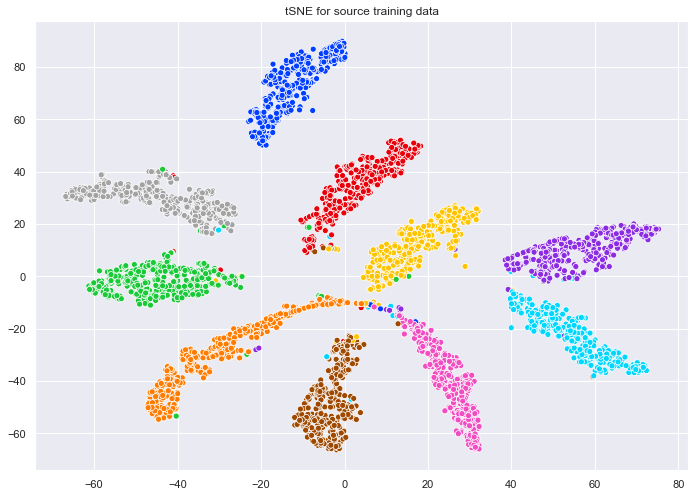

In [69]:
# Evalualtion

from sklearn.manifold import TSNE
import seaborn as sns

source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source training data')


 36%|███▌      | 9/25 [00:00<00:00, 18.33it/s]


Text(0.5, 1.0, 'tSNE for source testing data')

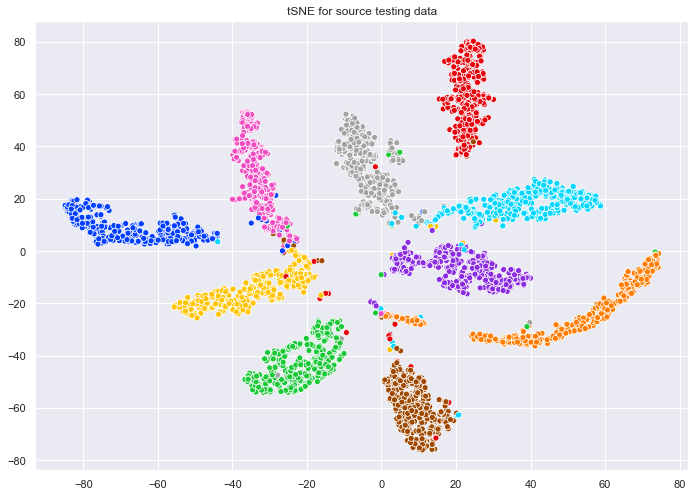

In [73]:
source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(test_mnist_loader), total=len(test_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source testing data')


  5%|▍         | 9/184 [00:00<00:15, 10.95it/s]


Text(0.5, 1.0, 'tSNE for target testing data')

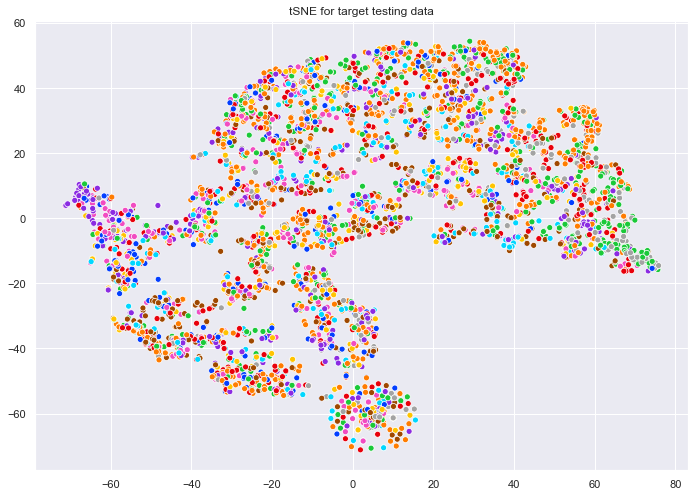

In [70]:

target_x_all = torch.empty(0,).to(device)
target_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (target_x, target_y) in tqdm(enumerate(test_svhn_loader), total=len(test_svhn_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    target_x = target_x.to(device).float()
    target_y = target_y.to(device)
    target_x_all = torch.cat([target_x_all, target_x], dim=0)
    target_y_all = torch.cat([target_y_all, target_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
target_x_embedding_all = encoder(target_x_all)
last_layer = CNet(target_x_embedding_all)
target_x_embedding_all.shape


target_tsne = TSNE()
target_tsne_res = target_tsne.fit_transform(target_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(target_tsne_res[:,0], target_tsne_res[:,1], hue=target_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for target testing data')